In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
from torch.utils.data import Dataset, DataLoader

In [5]:
!pip install pydicom
import pydicom

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Heart Detection/rsna_heart_detection.csv')

In [9]:
df.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [10]:
image_names = df['name']

In [11]:
image_names

0      ca112a3c-b701-48b8-a94f-725ea65416a7
1      e5f292ae-f1e5-497c-b0a0-68f1aa2196b2
2      67af68f7-7ba0-49a0-a373-3a8801eb0faa
3      814289a3-9ce8-4cba-842f-45d6a36f540d
4      e508969f-c931-462b-aa90-ccde34a4d9e5
                       ...                 
491    7e413a9c-e331-4188-999c-7cf064cb2417
492    6ab9618a-7d03-432f-8874-8596de1bfe26
493    5f531888-0bcd-44fa-8acb-9f5b71609c38
494    414e4a00-bec4-4552-92d3-7e710b367869
495    d15fd998-0f0f-44cb-850e-ead59d46a231
Name: name, Length: 496, dtype: object

In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/Pneumonia Classification/stage_2_train_labels.csv')
cleaned_train_labels = train_labels.drop_duplicates("patientId")
cleaned_train_labels = cleaned_train_labels.drop(columns=['x','y','width','height'])
ORIGINAL_PATH = '/content/drive/MyDrive/Pneumonia Classification/stage_2_train_images'
HEART_DATA_PATH = '/content/drive/MyDrive/Heart_Detection_Dataset'


In [ ]:
cleaned_train_labels['patientId']

In [ ]:
i=0
for patientId in cleaned_train_labels['patientId']:
  image_path = os.path.join(ORIGINAL_PATH,patientId+'.dcm')
  image = pydicom.read_file(image_path)
  image = image.pixel_array/255
  resized_image = cv2.resize(image,(224,224)).astype(np.float16)

  for heartPatientId in image_names:
    train_or_val = 'train' if i<400 else 'val'
    if heartPatientId == patientId:
      processed_path = os.path.join(HEART_DATA_PATH,train_or_val + '/' + patientId)
      dicom_path = os.makedirs(os.path.dirname(processed_path),exist_ok=True)
      np.save(processed_path,resized_image)
      i+=1

In [ ]:
df.iloc[0,5]

In [ ]:
df.iloc[:,1:5]

In [12]:
BOUNDING_BOX_DIR = '/content/drive/MyDrive/Heart Detection/rsna_heart_detection.csv'
TRAIN_IMAGE_DIR = '/content/drive/MyDrive/Heart_Detection_Dataset/train'
VAL_IMAGE_DIR = '/content/drive/MyDrive/Heart_Detection_Dataset/val'


In [24]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.494, std = 0.252)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
# batch_size = 32
# num_workers = 2
# shuffle = True
# train_dataset = HeartDetectionDataset(BOUNDING_BOX_DIR,TRAIN_IMAGE_DIR,transform)
# train_loader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=shuffle)

# val_dataset = HeartDetectionDataset(BOUNDING_BOX_DIR,VAL_IMAGE_DIR,transform)
# val_loader = DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=shuffle)

In [ ]:
image_names[5]

In [25]:
count=0
train_labels = []
val_labels = []
train_path = os.listdir('/content/drive/MyDrive/Heart_Detection_Dataset/train')
TRAIN_DIR = '/content/drive/MyDrive/Heart_Detection_Dataset/train'
val_path = os.listdir('/content/drive/MyDrive/Heart_Detection_Dataset/val')
VAL_DIR = '/content/drive/MyDrive/Heart_Detection_Dataset/val'

for i in range(len(image_names)):
  img_name = image_names[i]
  for j in range(len(train_path)):
    if train_path[j].split('.')[0] == img_name:
      train_labels.append([TRAIN_DIR+'/'+train_path[j],df.iloc[i,1:5].values])

for i in range(len(image_names)):
  img_name = image_names[i]
  for j in range(len(val_path)):
    if val_path[j].split('.')[0] == img_name:
      val_labels.append([VAL_DIR+'/'+val_path[j],df.iloc[i,1:5].values])



In [26]:
class HeartDetectionDataset(Dataset):
  def __init__(self,labels = None, transform=None):
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    img_path = self.labels[idx][0]
    bounding_box = self.labels[idx][1]
    image = np.load(img_path).astype(np.float32)
    x_min = bounding_box[0]
    y_min = bounding_box[1]
    x_max = x_min + bounding_box[2]
    y_max = y_min + bounding_box[3]
    bbox = torch.tensor([x_min,y_min,x_max,y_max],dtype=torch.float32)
    if self.transform:
      image = self.transform(image)
    return image,bbox

In [27]:
batch_size = 32
num_workers = 2
shuffle = True
train_dataset = HeartDetectionDataset(train_labels,train_transform)
train_loader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=shuffle)

val_dataset = HeartDetectionDataset(val_labels,val_transform)
val_loader = DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=shuffle)

In [28]:
class HeartDetectionModel(nn.Module):
  def __init__(self):
    super(HeartDetectionModel,self).__init__()

    self.model = models.vgg16(pretrained = True)
    self.model.features[0] = nn.Conv2d(1,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    self.relu1 = nn.ReLU()
    self.fcadded1 = nn.Linear(in_features = 1000, out_features = 128)
    self.relu2 = nn.ReLU()
    self.fcadded2 = nn.Linear(in_features = 128, out_features = 64)
    self.relu3 = nn.ReLU()
    self.fcadded3 = nn.Linear(in_features = 64, out_features = 32)
    self.relu4 = nn.ReLU()
    self.fcadded4 = nn.Linear(in_features = 32, out_features = 4)

  def forward(self,x):
    x = self.model(x)
    x = self.relu1(x)
    x = self.fcadded1(x)
    x = self.relu2(x)
    x = self.fcadded2(x)
    x = self.relu3(x)
    x = self.fcadded3(x)
    x = self.relu4(x)
    x = self.fcadded4(x)
    return x



In [29]:
model = HeartDetectionModel()
model = model.to('cuda')
optimizer = optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 25

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for batch_idx,(images,bbox) in enumerate(train_loader):
    images = images.to('cuda')
    bbox = bbox.to('cuda')
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,bbox)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if batch_idx % 10 == 0:
      print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

  print(f'Epoch: {epoch}, Training Loss: {running_loss / len(train_loader):.4f}')

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for batch_idx, (images,bbox) in enumerate(val_loader):
      images = images.to('cuda')
      bbox = bbox.to('cuda')
      outputs = model(images)
      val_loss += criterion(outputs,bbox).item()

  print(f'Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader):.4f}')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 16830.9570
Epoch: 0, Batch: 10, Loss: 15357.0410
Epoch: 0, Training Loss: 13461.5764
Epoch: 0, Validation Loss: 9516.0394
Epoch: 1, Batch: 0, Loss: 7579.6035
Epoch: 1, Batch: 10, Loss: 3248.4023
Epoch: 1, Training Loss: 5328.6772
Epoch: 1, Validation Loss: 3967.5858
Epoch: 2, Batch: 0, Loss: 2697.1704
Epoch: 2, Batch: 10, Loss: 755.2633
Epoch: 2, Training Loss: 1591.5834
Epoch: 2, Validation Loss: 1800.4420
Epoch: 3, Batch: 0, Loss: 1208.3394
Epoch: 3, Batch: 10, Loss: 453.0201
Epoch: 3, Training Loss: 579.0590
Epoch: 3, Validation Loss: 336.8141
Epoch: 4, Batch: 0, Loss: 356.6760
Epoch: 4, Batch: 10, Loss: 294.3014
Epoch: 4, Training Loss: 289.7704
Epoch: 4, Validation Loss: 354.9938
Epoch: 5, Batch: 0, Loss: 181.5156
Epoch: 5, Batch: 10, Loss: 292.4824
Epoch: 5, Training Loss: 243.8061
Epoch: 5, Validation Loss: 271.9637
Epoch: 6, Batch: 0, Loss: 210.3892
Epoch: 6, Batch: 10, Loss: 286.1489
Epoch: 6, Training Loss: 229.5002
Epoch: 6, Validation Loss: 244.181

In [31]:
num_images = 10
model.eval()
with torch.no_grad():
  for batch_idx, (images,bbox) in enumerate(val_loader):
    images = images.to('cuda')
    bbox = bbox.to('cuda')
    outputs = model(images)
    for i in range(num_images):
      print(f'Prediction: {outputs.cpu()[i]}, Ground Truth: {bbox[i]}')



Prediction: tensor([ 80.2001,  56.4702, 150.6006, 149.1370]), Ground Truth: tensor([ 91.,  61., 171., 164.], device='cuda:0')
Prediction: tensor([ 79.9142,  56.2763, 149.7811, 148.1674]), Ground Truth: tensor([ 98.,  69., 167., 169.], device='cuda:0')
Prediction: tensor([ 80.8697,  57.0006, 151.9770, 150.1995]), Ground Truth: tensor([ 91.,  66., 170., 152.], device='cuda:0')
Prediction: tensor([ 74.7449,  52.5555, 140.0855, 138.9348]), Ground Truth: tensor([ 85.,  52., 174., 126.], device='cuda:0')
Prediction: tensor([ 80.7465,  56.8747, 151.6353, 150.1565]), Ground Truth: tensor([ 85.,  61., 170., 154.], device='cuda:0')
Prediction: tensor([ 81.4962,  57.1880, 152.4627, 151.5063]), Ground Truth: tensor([ 93.,  60., 153., 158.], device='cuda:0')
Prediction: tensor([ 78.1704,  55.1126, 146.7075, 144.9849]), Ground Truth: tensor([ 86.,  56., 161., 118.], device='cuda:0')
Prediction: tensor([ 78.6806,  55.2559, 147.2840, 146.3052]), Ground Truth: tensor([ 81.,  80., 168., 163.], device='c

Prediction: [ 80.9403    56.886528 151.81477  150.66003 ], Ground Truth: [ 87.  70. 168. 184.]
Prediction: [ 79.671936  55.768723 148.9726   148.32953 ], Ground Truth: [ 86.  70. 157. 187.]
Prediction: [ 75.0087    52.892452 140.80272  139.25052 ], Ground Truth: [ 93.  48. 164. 123.]
Prediction: [ 78.47221  55.19262 146.96875 145.73709], Ground Truth: [107.  66. 186. 181.]
Prediction: [ 82.72041  58.27767 155.34329 153.59135], Ground Truth: [ 93.  56. 173. 173.]
Prediction: [ 82.32982  57.6279  154.06747 153.60825], Ground Truth: [ 84.  73. 157. 191.]


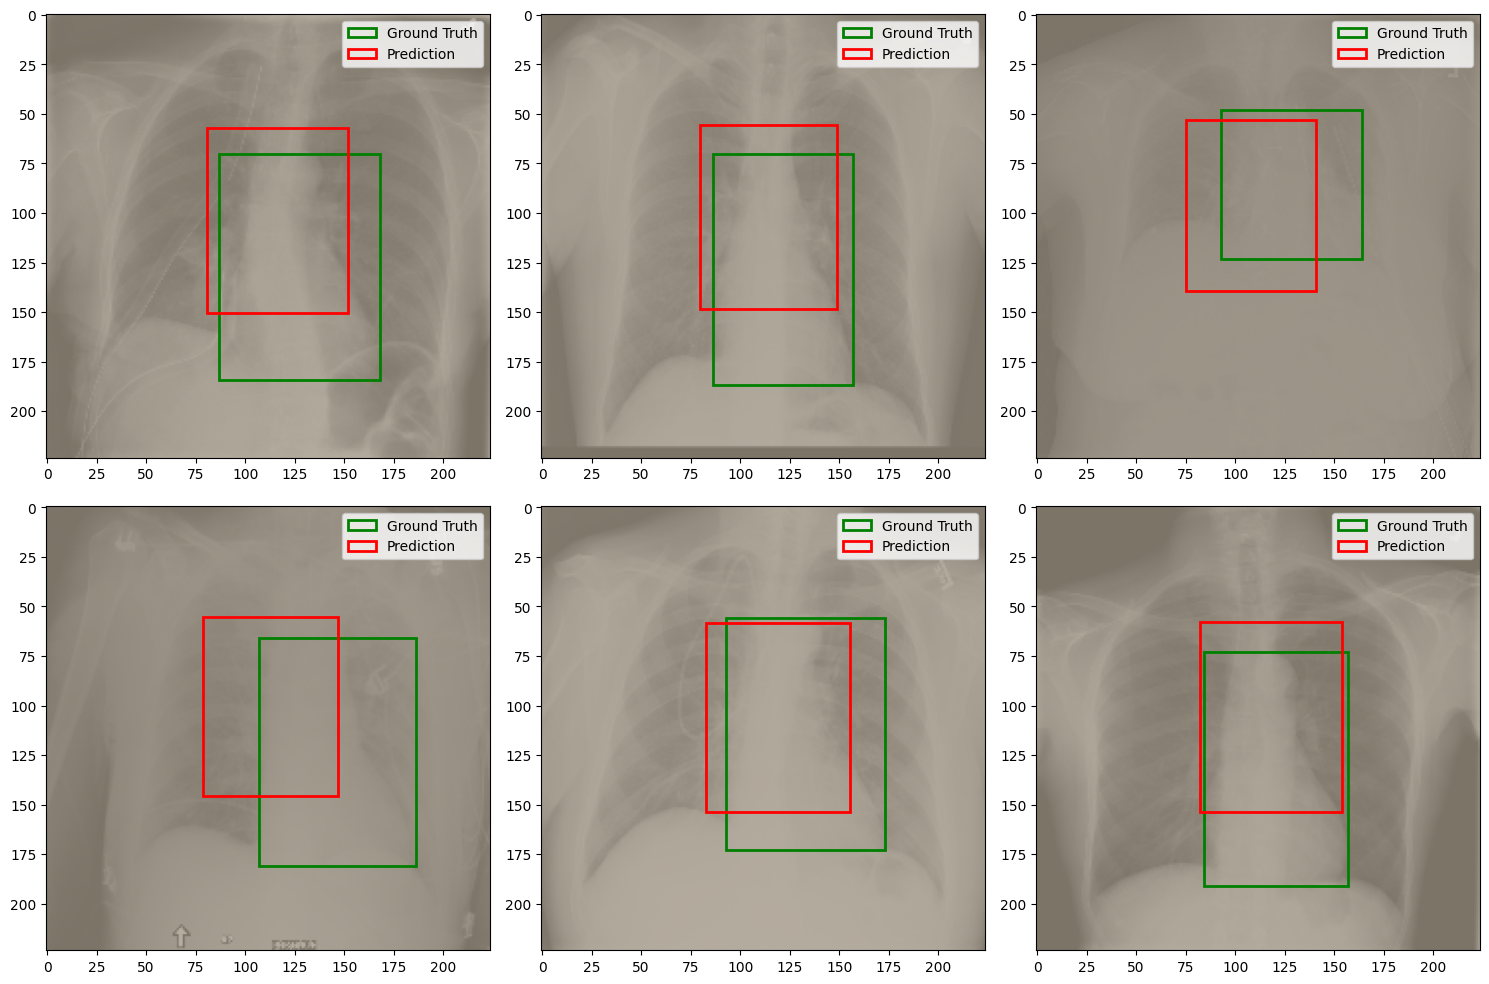

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_image_with_bboxes(image, gt_bbox, pred_bbox, ax):
    """
    Plots a single image with ground truth and predicted bounding boxes.
    """
    # Unnormalize the image and convert from Tensor to Numpy
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Plot the image
    ax.imshow(image)

    # Create a rectangle patch for the ground truth bounding box
    gt_rect = patches.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1],
                                linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
    ax.add_patch(gt_rect)

    # Create a rectangle patch for the predicted bounding box
    pred_rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1],
                                  linewidth=2, edgecolor='r', facecolor='none', label='Prediction')
    ax.add_patch(pred_rect)

    # Add legends
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)

num_images = 6
model.eval()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

with torch.no_grad():
    for batch_idx, (images, bbox) in enumerate(val_loader):
        images = images.to('cuda')
        bbox = bbox.to('cuda')
        outputs = model(images)

        for i in range(num_images):
            gt_bbox = bbox[i].cpu().numpy()
            pred_bbox = outputs[i].cpu().numpy()

            print(f'Prediction: {pred_bbox}, Ground Truth: {gt_bbox}')
            row = i // 3
            col = i % 3
            plot_image_with_bboxes(images[i], gt_bbox, pred_bbox, axes[row, col])

        break  # Only process one batch for demonstration purposes

plt.tight_layout()
plt.show()


In [47]:
class HeartDetectionModel2(nn.Module):
  def __init__(self):
    super(HeartDetectionModel2,self).__init__()

    self.model = models.vgg16(pretrained = True)
    self.model.features[0] = nn.Conv2d(1,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    self.model.classifier[6] = nn.Linear(in_features = 4096, out_features = 4)

  def forward(self,x):
    x = self.model(x)
    return x



In [48]:
model2 = HeartDetectionModel2()
model2 = model2.to('cuda')
optimizer = optim.Adam(model2.parameters(),lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 20

for epoch in range(num_epochs):
  model2.train()
  running_loss = 0.0
  for batch_idx,(images,bbox) in enumerate(train_loader):
    images = images.to('cuda')
    bbox = bbox.to('cuda')
    optimizer.zero_grad()
    outputs = model2(images)
    loss = criterion(outputs,bbox)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if batch_idx % 10 == 0:
      print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

  print(f'Epoch: {epoch}, Training Loss: {running_loss / len(train_loader):.4f}')

  model2.eval()
  val_loss = 0.0
  with torch.no_grad():
    for batch_idx, (images,bbox) in enumerate(val_loader):
      images = images.to('cuda')
      bbox = bbox.to('cuda')
      outputs = model2(images)
      val_loss += criterion(outputs,bbox).item()

  print(f'Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader):.4f}')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 16961.0898
Epoch: 0, Batch: 10, Loss: 1702.7172
Epoch: 0, Training Loss: 8133.5125
Epoch: 0, Validation Loss: 5533.5828
Epoch: 1, Batch: 0, Loss: 2507.2651
Epoch: 1, Batch: 10, Loss: 1311.2522
Epoch: 1, Training Loss: 1125.6413
Epoch: 1, Validation Loss: 775.0391
Epoch: 2, Batch: 0, Loss: 509.6759
Epoch: 2, Batch: 10, Loss: 360.1959
Epoch: 2, Training Loss: 463.4251
Epoch: 2, Validation Loss: 307.9123
Epoch: 3, Batch: 0, Loss: 359.0803
Epoch: 3, Batch: 10, Loss: 342.1094
Epoch: 3, Training Loss: 347.3500
Epoch: 3, Validation Loss: 235.3287
Epoch: 4, Batch: 0, Loss: 323.7605
Epoch: 4, Batch: 10, Loss: 369.6175
Epoch: 4, Training Loss: 324.7214
Epoch: 4, Validation Loss: 225.4798
Epoch: 5, Batch: 0, Loss: 287.9416
Epoch: 5, Batch: 10, Loss: 331.7643
Epoch: 5, Training Loss: 310.1925
Epoch: 5, Validation Loss: 263.5608
Epoch: 6, Batch: 0, Loss: 317.1371
Epoch: 6, Batch: 10, Loss: 369.4141
Epoch: 6, Training Loss: 298.3908
Epoch: 6, Validation Loss: 253.9736
Epoch

Prediction: [ 78.65408  47.93978 162.48167 132.45589], Ground Truth: [ 93.  45. 188. 150.]
Prediction: [ 80.93377   51.633335 168.44461  138.73149 ], Ground Truth: [ 85.  58. 182. 142.]
Prediction: [ 78.16573  57.80985 160.70245 151.88347], Ground Truth: [ 91.  68. 166. 169.]
Prediction: [ 80.53874  52.47655 167.16603 139.24739], Ground Truth: [ 82.  60. 177. 159.]
Prediction: [ 80.97462   54.155106 165.65031  144.61436 ], Ground Truth: [ 98.  69. 167. 169.]
Prediction: [ 79.86652   51.665375 165.6351   135.46889 ], Ground Truth: [ 87.  65. 191. 164.]


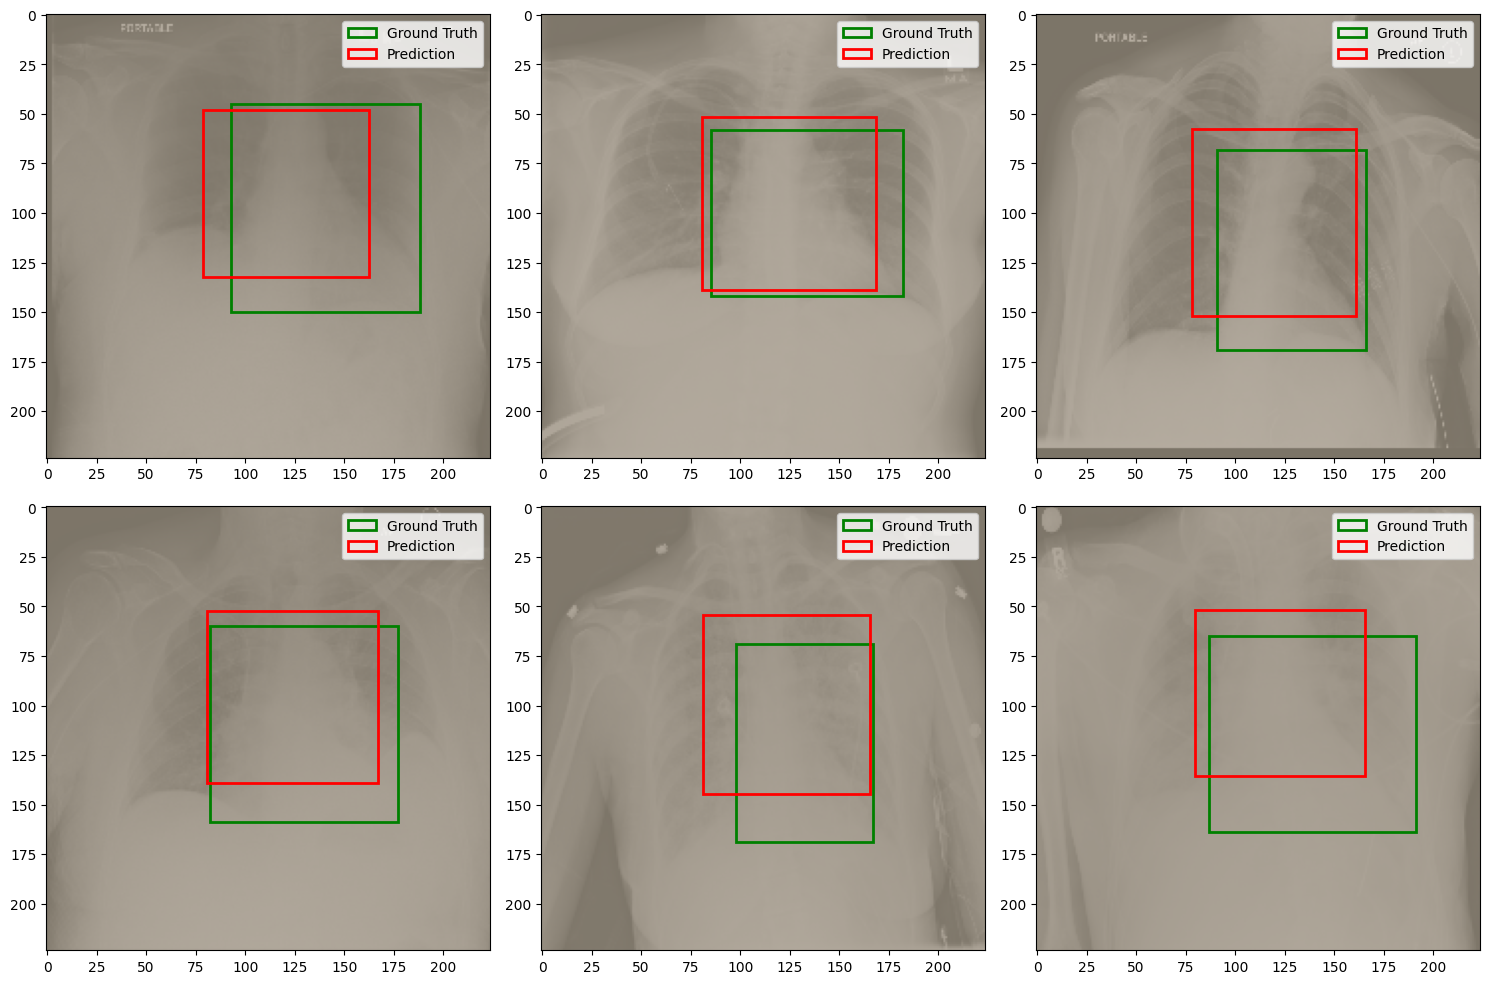

In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_image_with_bboxes(image, gt_bbox, pred_bbox, ax):
    """
    Plots a single image with ground truth and predicted bounding boxes.
    """
    # Unnormalize the image and convert from Tensor to Numpy
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Plot the image
    ax.imshow(image)

    # Create a rectangle patch for the ground truth bounding box
    gt_rect = patches.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1],
                                linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
    ax.add_patch(gt_rect)

    # Create a rectangle patch for the predicted bounding box
    pred_rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1],
                                  linewidth=2, edgecolor='r', facecolor='none', label='Prediction')
    ax.add_patch(pred_rect)

    # Add legends
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)

num_images = 6
model2.eval()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

with torch.no_grad():
    for batch_idx, (images, bbox) in enumerate(val_loader):
        images = images.to('cuda')
        bbox = bbox.to('cuda')
        outputs = model2(images)

        for i in range(num_images):
            gt_bbox = bbox[i].cpu().numpy()
            pred_bbox = outputs[i].cpu().numpy()

            print(f'Prediction: {pred_bbox}, Ground Truth: {gt_bbox}')
            row = i // 3
            col = i % 3
            plot_image_with_bboxes(images[i], gt_bbox, pred_bbox, axes[row, col])

        break  # Only process one batch for demonstration purposes

plt.tight_layout()
plt.show()
